In [1]:
import os
os.environ["FIFT_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"

import time, pathlib
import numpy as np
import matplotlib.pyplot as plt

from fift import set_num_threads, FresnelNUFFT3Vec
from fift.compare_utils import plot_overlays_ws
from glow import time_domain_c, freq_domain_c

set_num_threads(112)

def check_precomputed_gl_files(n_gl, Umax, directory):
    if not directory:
        raise RuntimeError("FIFT_GL2D_DIR is not set.")
    path_base = f"gl2d_n{n_gl}_U{int(Umax)}"
    required = [
        f"{path_base}.u1.npy",
        f"{path_base}.u2.npy",
        f"{path_base}.W.npy",
        f"{path_base}.meta.json",
    ]
    missing = []
    for fname in required:
        if not pathlib.Path(directory, fname).exists():
            missing.append(fname)
    if missing:
        raise FileNotFoundError(
            f"The following precomputed GL2D files are missing in {directory}:\n  "
            + "\n  ".join(missing)
        )
    else:
        print(f"All precomputed GL2D files found in {directory} for n={n_gl}, Umax={Umax}.\n")


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# NFW subhalos

In [2]:
def m200_c_to_psi0_xs(M, M_host, c, c_host, psi0_host, xs_host):

    M   = np.asarray(M, dtype=float)
    M_h = float(M_host)
    c   = float(c)
    c_h = float(c_host)

    def f(cval):
        return np.log(1.0 + cval) - cval/(1.0 + cval)

    # Scale xs with r_s ∝ M^{1/3}/c
    xs = xs_host * (M/M_h)**(1.0/3.0) * (c_h/c)

    # Scale psi0 with M / f(c)
    psi0 = psi0_host * (M/M_h) * (f(c_h)/f(c))

    return psi0, xs


In [3]:
from glow import lenses as glow_lenses
from fift.lenses import JAXClumpyNFWLens

import numpy as np
import matplotlib.pyplot as plt

from glow import lenses as glow_lenses
from fift.lenses import JAXClumpyNFWLens
# from fift.lenses import ClumpyNFWLens  # if you ever go back to the non-JAX version

def build_clumpy_NFW_profile(
    n_sub=20,
    M_host=1e12,
    M_min=1e7,
    M_max=1e10,
    c_host=15.0,
    c_sub=15.0,
    psi0_host_ref=1.0,
    xs_host_ref=0.1,
    R_max=0.5,
    seed=1234,
):

    rng = np.random.default_rng(seed)

    # ----- Host normalization -----
    psi0_h, xs_h = m200_c_to_psi0_xs(
        M_host, M_host, c_host, c_host, psi0_host_ref, xs_host_ref
    )

    # ----- Subhalo masses, concentrations -----
    logM = rng.uniform(np.log10(M_min), np.log10(M_max), size=n_sub)
    M_sub = 10.0**logM

    psi0_sub, xs_sub = m200_c_to_psi0_xs(
        M_sub, M_host, c_sub, c_host, psi0_host_ref, xs_host_ref
    )

    # ----- Subhalo positions in a disk of radius R_max -----
    R  = R_max * np.sqrt(rng.uniform(0.0, 1.0, size=n_sub))
    th = rng.uniform(0.0, 2.0*np.pi, size=n_sub)
    xc1_sub = R * np.cos(th)
    xc2_sub = R * np.sin(th)

    # ------------------------ FIFT lens ------------------------
    lens_fift = JAXClumpyNFWLens(
        psi0_host=psi0_h,
        xs_host=xs_h,
        psi0_sub=psi0_sub,
        xs_sub=xs_sub,
        xc1_sub=xc1_sub,
        xc2_sub=xc2_sub,
    )

    # ------------------------ GLoW lens ------------------------
    host_glow = glow_lenses.Psi_NFW(
        {'psi0': psi0_h, 'xs': xs_h},
        {'eps_soft': 1e-15, 'eps_NFW': 0.01},
    )

    lenses_glow = [host_glow]

    for psi0_i, xs_i, xc1_i, xc2_i in zip(
        psi0_sub, xs_sub, xc1_sub, xc2_sub
    ):
        sub_i = glow_lenses.Psi_offcenterNFW(
            {
                'psi0': float(psi0_i),
                'xs':  float(xs_i),
                'xc1': float(xc1_i),
                'xc2': float(xc2_i),
            },
            {'eps_soft': 1e-15, 'eps_NFW': 0.01},
        )
        lenses_glow.append(sub_i)

    Psi_glow = glow_lenses.CombinedLens({'lenses': lenses_glow}, {})

    meta = {
        "M_host":    M_host,
        "c_host":    c_host,
        "M_sub":     M_sub,
        "c_sub":     c_sub,
        "psi0_host": psi0_h,
        "xs_host":   xs_h,
        "psi0_sub":  psi0_sub,
        "xs_sub":    xs_sub,
        "xc1_sub":   xc1_sub,
        "xc2_sub":   xc2_sub,
    }

    return lens_fift, Psi_glow, meta


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clumpy_NFW_potential(
    lens_fift,
    meta,
    R_plot=None,
    n_grid=201,
    ax=None,
    cmap="viridis",
    show_host=True,
    show_subhalos=True,
    title=None,
):

    xc1_sub = meta.get("xc1_sub", None)
    xc2_sub = meta.get("xc2_sub", None)

    # Try to guess a plotting radius if not provided
    if R_plot is None:
        if xc1_sub is not None and xc2_sub is not None and len(xc1_sub) > 0:
            r_sub = np.sqrt(xc1_sub**2 + xc2_sub**2)
            R_plot = 1.2 * max(np.max(r_sub), 1e-3)
        else:
            R_plot = 0.5  # default fallback

    x1 = np.linspace(-R_plot, R_plot, n_grid)
    x2 = np.linspace(-R_plot, R_plot, n_grid)
    X1, X2 = np.meshgrid(x1, x2, indexing="xy")

    # Evaluate potential using FIFT lens
    psi_xy = lens_fift.psi_xy(X1, X2)
    psi_re = np.real(psi_xy)

    # Setup axes / figure
    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
        created_fig = True
    else:
        fig = ax.figure

    im = ax.pcolormesh(
        X1, X2, psi_re,
        shading="auto",
        cmap=cmap,
    )
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"$\psi(x_1,x_2)$")

    # Mark host (assumed at origin)
    if show_host:
        ax.scatter(0.0, 0.0, marker="*", s=120,
                   color="white", edgecolor="k", label="Host")

    # Mark subhalos
    if show_subhalos and xc1_sub is not None and xc2_sub is not None:
        ax.scatter(
            xc1_sub, xc2_sub,
            marker="o", s=40,
            color="red", alpha=0.8, label="Subhalos"
        )

    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    if title is None:
        ax.set_title("Clumpy NFW lens: $\psi(x_1,x_2)$")
    else:
        ax.set_title(title)

    ax.set_aspect("equal", adjustable="box")
    ax.legend(loc="upper right", fontsize=9)
    ax.set_xlim(-R_plot, R_plot)
    ax.set_ylim(-R_plot, R_plot)

    fig.tight_layout()

    if created_fig:
        plt.show()

    return fig, ax

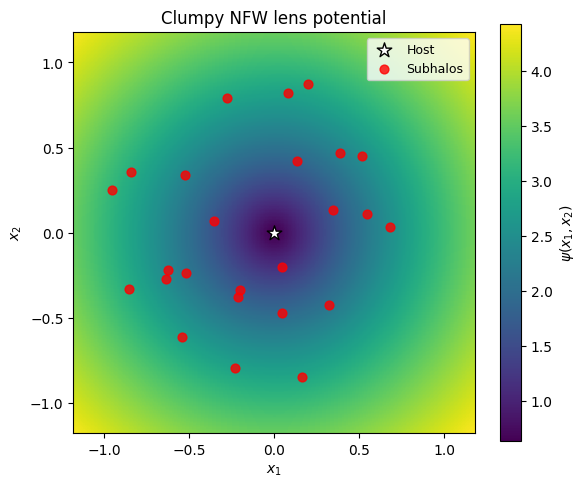

In [5]:
n_sub=25
seed = 42
M_host = 1e12
M_min = 1e9
M_max = 1e10
c_host = 10.0
c_sub = 15
psi0_host_ref=1.0
xs_host_ref=0.1
R_max=1.0

lens_fift, Psi_glow, meta = build_clumpy_NFW_profile(
    n_sub=n_sub,
    M_host=M_host,
    M_min=M_min,
    M_max=M_max,
    c_host=c_host,
    c_sub=c_sub,
    psi0_host_ref=psi0_host_ref,
    xs_host_ref=xs_host_ref,
    R_max=R_max,
    seed=seed)

fig, ax = plot_clumpy_NFW_potential(
    lens_fift,
    meta,
    R_plot=None,
    n_grid=301,
    title="Clumpy NFW lens potential")

In [20]:
def compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=100,
    Umax=20,
    eps=1e-2,
    w_grid=None,
    y_star=(0.3, 0.1),
    shared_Umax=True,
    seed=seed,
    colors=['blue', 'purple', 'magenta'],
):

    if w_grid is None:
        w_grid = np.logspace(0.0, 1.0, 50)
    w_grid = np.asarray(w_grid, dtype=float)

    y1, y2 = map(float, y_star)

    fift_gl2d_dir = os.environ.get("FIFT_GL2D_DIR")
    check_precomputed_gl_files(n_gl, Umax, fift_gl2d_dir)

    results = {}

    plt.figure(figsize=(7, 5))

    for (c_sub, color) in zip(c_sub_list, colors):
        print(f"\n=== c_sub = {c_sub:.1f} ===")

        # Build lenses
        lens_fift, Psi_glow, meta = build_clumpy_NFW_profile(
            n_sub=n_sub,
            M_host=M_host,
            M_min=M_min,
            M_max=M_max,
            c_host=c_host,
            c_sub=c_sub,
            psi0_host_ref=psi0_host_ref,
            xs_host_ref=xs_host_ref,
            R_max=R_max,
            seed=seed)

        # --------- FIFT ----------
        t0 = time.perf_counter()
        nu3v = FresnelNUFFT3Vec(
            lens_fift,
            n_gl=n_gl,
            Umax=Umax,
            eps=eps,
            shared_Umax=shared_Umax,
            numexpr_threads=64,)
        
        F_fift = nu3v(w_grid, np.array([y1]), np.array([y2]))[:, 0]
        t1 = time.perf_counter()
        t_fift = t1 - t0

        # --------- GLoW ----------
        t2 = time.perf_counter()
        It   = time_domain_c.It_MultiContour_C(Psi_glow, y=np.hypot(y1, y2))
        Fw   = freq_domain_c.Fw_FFT_C(It)
        F_glow = Fw(w_grid)
        t3 = time.perf_counter()
        t_glow = t3 - t2

        phase = np.angle(F_fift[0] / F_glow[0])
        F_glow_aligned = F_glow * np.exp(1j * phase)

        results[c_sub] = {
            "F_fift": F_fift,
            "F_glow": F_glow_aligned,
            "meta":   meta,
            "t_fift": t_fift,
            "t_glow": t_glow,}

        print(f"FIFT time (single run): {t_fift:.4f} s")
        print(f"GLoW time (single run): {t_glow:.4f} s")
        print(f"Speedup (GLoW/FIFT):    {t_glow/t_fift:.2f}×")

        plt.loglog(
            w_grid,
            np.abs(F_fift),
            label=f"FIFT, c_sub={c_sub:.0f}", color=color, alpha=0.7)
        plt.loglog(
            w_grid,
            np.abs(F_glow_aligned),
            linestyle="--",
            label=f"GLoW, c_sub={c_sub:.0f}", color=color)

    plt.xlabel(r"$w$")
    plt.ylabel(r"$|F(w)|$")
    plt.title(r"NFW Host + 20 NFW subhalos")
    plt.legend()
    plt.tight_layout()

    return results


All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=1000, Umax=200.


=== c_sub = 15.0 ===
FIFT time (single run): 10.7787 s
GLoW time (single run): 0.1056 s
Speedup (GLoW/FIFT):    0.01×

=== c_sub = 30.0 ===
FIFT time (single run): 10.6814 s
GLoW time (single run): 0.0966 s
Speedup (GLoW/FIFT):    0.01×

=== c_sub = 60.0 ===
FIFT time (single run): 9.0072 s
GLoW time (single run): 0.0760 s
Speedup (GLoW/FIFT):    0.01×


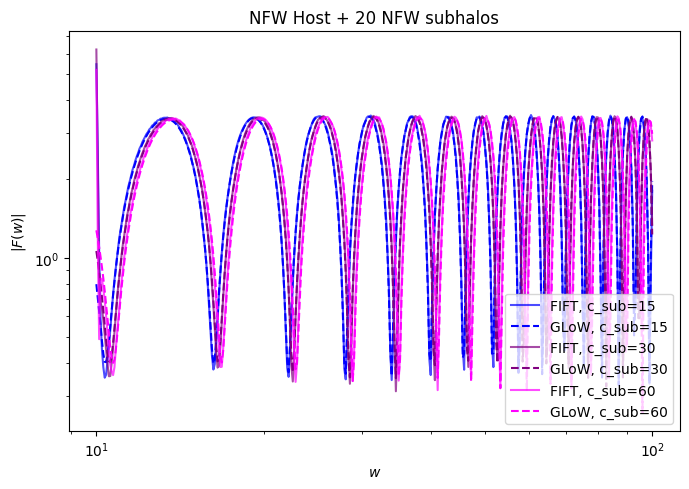

In [14]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=1000,
    Umax=200,
    eps=1e-2,
    w_grid=np.logspace(1., 2., 400),
    y_star=(0.3, 0.1),
    seed=seed)


All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=1000, Umax=200.


=== c_sub = 15.0 ===
FIFT time (single run): 11.1289 s
GLoW time (single run): 0.1054 s
Speedup (GLoW/FIFT):    0.01×

=== c_sub = 30.0 ===
FIFT time (single run): 12.0368 s
GLoW time (single run): 0.1232 s
Speedup (GLoW/FIFT):    0.01×

=== c_sub = 60.0 ===
FIFT time (single run): 11.3805 s
GLoW time (single run): 0.0996 s
Speedup (GLoW/FIFT):    0.01×


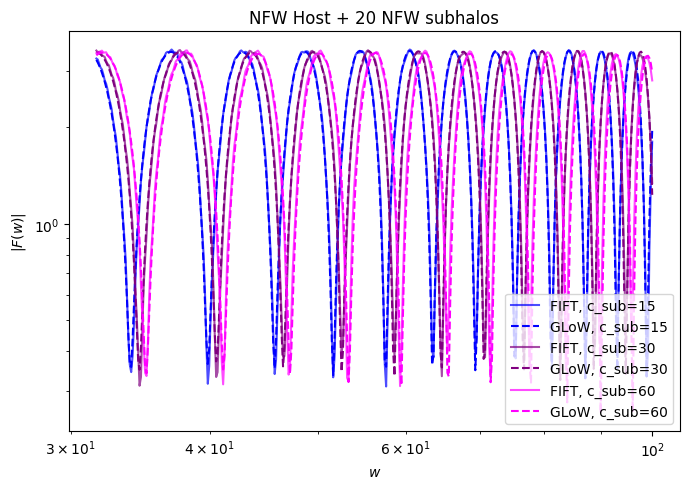

In [15]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=1000,
    Umax=200,
    eps=1e-2,
    w_grid=np.logspace(1.5, 2., 400),
    y_star=(0.3, 0.1),
    seed=seed)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=1000, Umax=20.


=== c_sub = 15.0 ===
FIFT time (single run): 7.3280 s
GLoW time (single run): 0.1141 s
Speedup (GLoW/FIFT):    0.02×

=== c_sub = 60.0 ===
FIFT time (single run): 5.1533 s
GLoW time (single run): 0.1047 s
Speedup (GLoW/FIFT):    0.02×


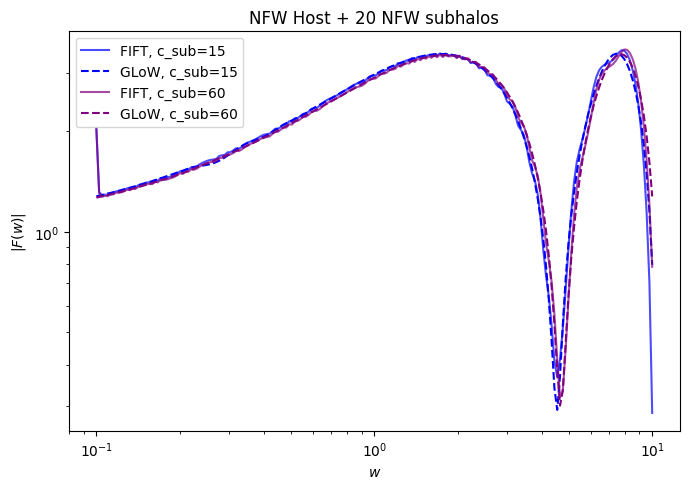

In [16]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 60.0),
    n_gl=1000,
    Umax=20,
    eps=1e-2,
    w_grid=np.logspace(-1., 1., 200),
    y_star=(0.3, 0.1),
    seed=seed)


All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=20.


=== c_sub = 15.0 ===
FIFT time (single run): 2.1932 s
GLoW time (single run): 0.0938 s
Speedup (GLoW/FIFT):    0.04×

=== c_sub = 30.0 ===
FIFT time (single run): 2.2301 s
GLoW time (single run): 0.1090 s
Speedup (GLoW/FIFT):    0.05×

=== c_sub = 60.0 ===
FIFT time (single run): 2.4016 s
GLoW time (single run): 0.1199 s
Speedup (GLoW/FIFT):    0.05×


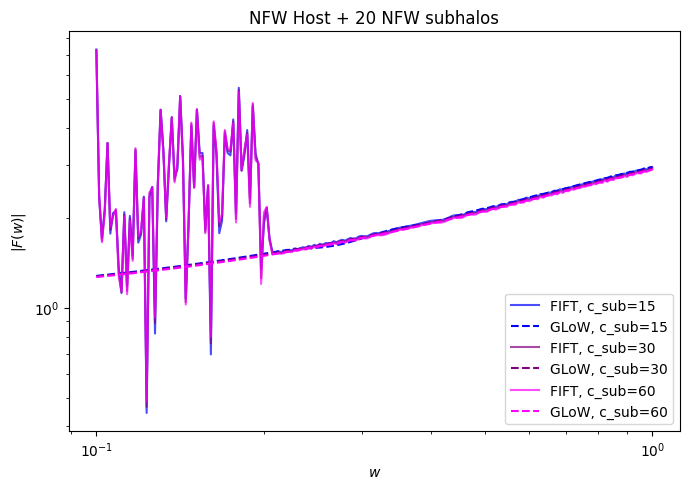

In [17]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=500,
    Umax=20,
    eps=1e-2,
    w_grid=np.logspace(-1., 0., 200),
    y_star=(0.3, 0.1),
    seed=seed)


All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=100, Umax=50.


=== c_sub = 15.0 ===
FIFT time (single run): 0.4386 s
GLoW time (single run): 0.1083 s
Speedup (GLoW/FIFT):    0.25×

=== c_sub = 30.0 ===
FIFT time (single run): 0.5061 s
GLoW time (single run): 0.1081 s
Speedup (GLoW/FIFT):    0.21×

=== c_sub = 60.0 ===
FIFT time (single run): 0.3944 s
GLoW time (single run): 0.1091 s
Speedup (GLoW/FIFT):    0.28×


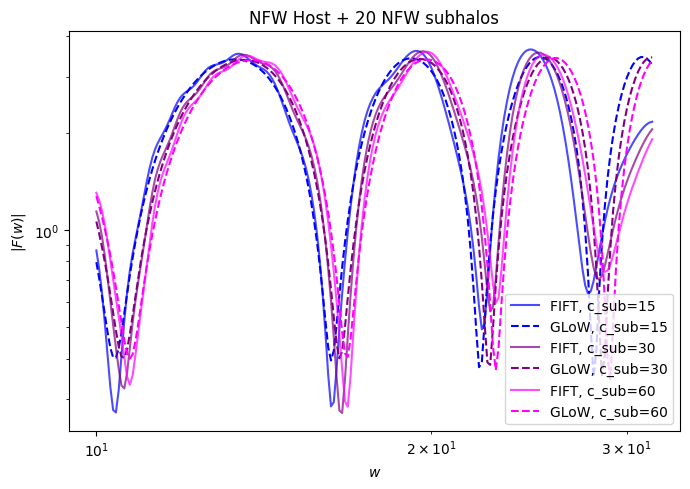

In [18]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=100,
    Umax=50,
    eps=1e-2,
    w_grid=np.logspace(1., 1.5, 200),
    y_star=(0.3, 0.1),
    seed=seed)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=100, Umax=7.


=== c_sub = 15.0 ===
FIFT time (single run): 0.5070 s
GLoW time (single run): 0.1528 s
Speedup (GLoW/FIFT):    0.30×

=== c_sub = 30.0 ===
FIFT time (single run): 0.6720 s
GLoW time (single run): 0.1108 s
Speedup (GLoW/FIFT):    0.16×

=== c_sub = 60.0 ===
FIFT time (single run): 0.4831 s
GLoW time (single run): 0.1514 s
Speedup (GLoW/FIFT):    0.31×


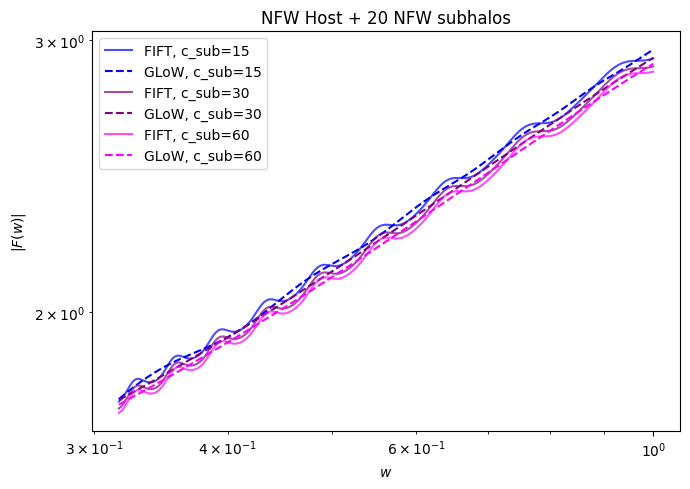

In [19]:
results_nfw = compare_clumpyNFW_concentration_sweep(
    c_sub_list=(15.0, 30.0, 60.0),
    n_gl=100,
    Umax=7,
    eps=1e-2,
    w_grid=np.logspace(-0.5, 0., 200),
    y_star=(0.3, 0.1),
    seed=seed,
)
